In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp

def robertson(t, y):
    y1, y2, y3 = y
    dy1 = -0.04*y1 + 1e4*y2*y3
    dy2 = 0.04*y1 - 1e4*y2*y3 - 3e7*(y2**2)
    dy3 = 3e7*(y2**2)
    return [dy1, dy2, dy3]

# Kondisi awal klasik Robertson
y0 = [1.0, 0.0, 0.0]

# Rentang waktu yang umum untuk melihat stiffness Robertson
t0, tf = 0.0, 1e5


Euler: GAGAL (nilai negatif / tidak fisik) | steps: 2 | time(s): 0.0


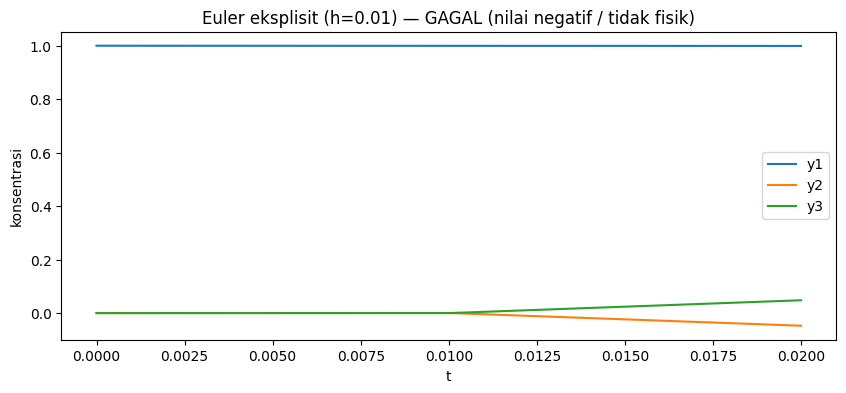

In [2]:
def euler_explicit(f, t_span, y0, h):
    t0, tf = t_span
    n = int(np.ceil((tf - t0) / h))
    t = np.zeros(n+1)
    y = np.zeros((n+1, len(y0)))
    t[0] = t0
    y[0] = y0

    status = "OK"
    for i in range(n):
        t[i+1] = t[i] + h
        y[i+1] = y[i] + h*np.array(f(t[i], y[i]))

        # indikator gagal numerik / tidak fisik
        if (not np.isfinite(y[i+1]).all()):
            status = "GAGAL (NaN/Inf)"
            t, y = t[:i+2], y[:i+2]
            break
        if np.max(np.abs(y[i+1])) > 1e6:
            status = "GAGAL (meledak > 1e6)"
            t, y = t[:i+2], y[:i+2]
            break
        if np.min(y[i+1]) < -1e-6:   # konsentrasi tidak boleh negatif
            status = "GAGAL (nilai negatif / tidak fisik)"
            t, y = t[:i+2], y[:i+2]
            break

    return t, y, status

h = 0.01
start = time.time()
t_eu, y_eu, status_eu = euler_explicit(robertson, (t0, tf), y0, h)
time_eu = time.time() - start

print("Euler:", status_eu, "| steps:", len(t_eu)-1, "| time(s):", time_eu)

plt.figure(figsize=(10,4))
plt.plot(t_eu, y_eu[:,0], label="y1")
plt.plot(t_eu, y_eu[:,1], label="y2")
plt.plot(t_eu, y_eu[:,2], label="y3")
plt.title(f"Euler eksplisit (h={h}) — {status_eu}")
plt.xlabel("t"); plt.ylabel("konsentrasi")
plt.legend(); plt.show()


In [3]:
t_eval = np.unique(np.concatenate([
    np.linspace(0, 1, 300),
    np.logspace(0, 5, 600)   # dari 10^0 sampai 10^5
]))
t_eval = t_eval[(t_eval >= t0) & (t_eval <= tf)]


In [4]:
def run_ivp(method):
    start = time.time()
    sol = solve_ivp(robertson, (t0, tf), y0, method=method, t_eval=t_eval)
    elapsed = time.time() - start
    return sol, elapsed

sol_rk45, time_rk45 = run_ivp("RK45")     # eksplisit adaptif
sol_bdf,  time_bdf  = run_ivp("BDF")      # stiff solver
sol_radau,time_radau= run_ivp("Radau")    # stiff solver
# LSODA kadang tersedia di SciPy; kalau error, abaikan.
try:
    sol_lsoda, time_lsoda = run_ivp("LSODA")
except Exception as e:
    sol_lsoda, time_lsoda = None, None
    print("LSODA tidak tersedia/bermasalah di environment:", e)

print("RK45 :", sol_rk45.message,  "nfev=", sol_rk45.nfev,  "time=", time_rk45)
print("BDF  :", sol_bdf.message,   "nfev=", sol_bdf.nfev,   "time=", time_bdf)
print("Radau:", sol_radau.message, "nfev=", sol_radau.nfev, "time=", time_radau)
if sol_lsoda is not None:
    print("LSODA:", sol_lsoda.message, "nfev=", sol_lsoda.nfev, "time=", time_lsoda)


RK45 : Required step size is less than spacing between numbers. nfev= 15554 time= 0.24782228469848633
BDF  : The solver successfully reached the end of the integration interval. nfev= 269 time= 0.05895113945007324
Radau: The solver successfully reached the end of the integration interval. nfev= 391 time= 0.02645111083984375
LSODA: The solver successfully reached the end of the integration interval. nfev= 283 time= 0.0060367584228515625


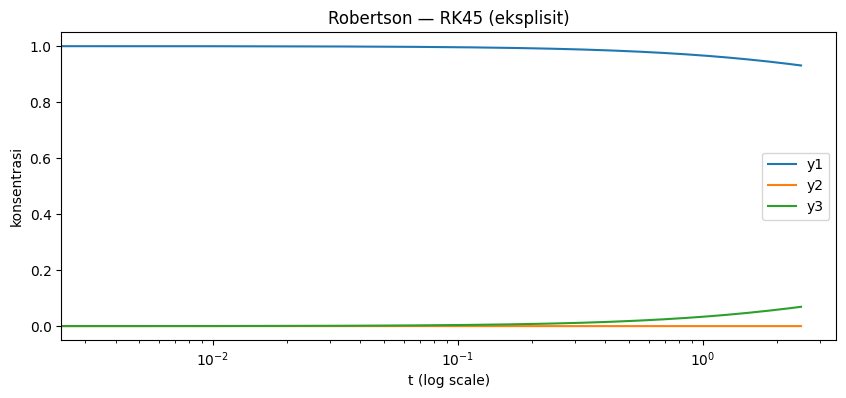

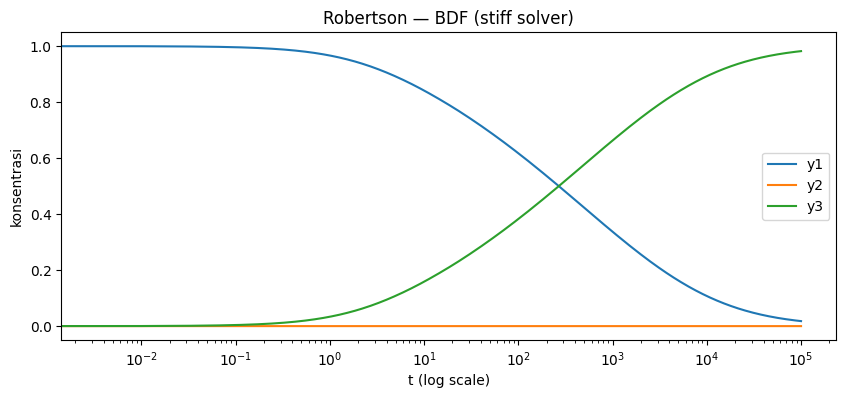

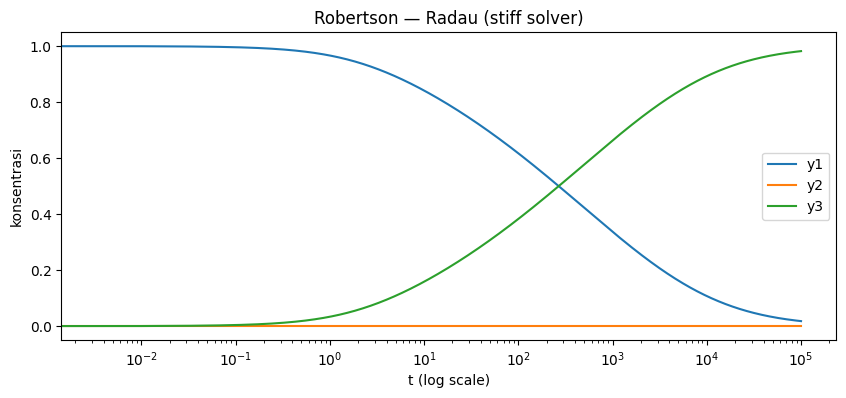

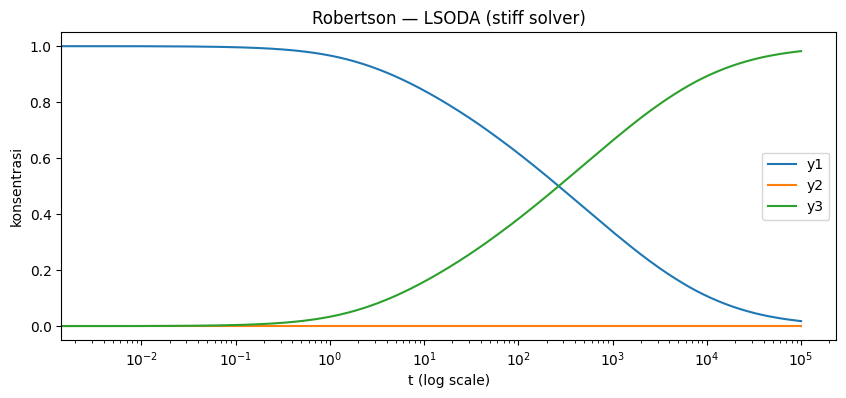

In [5]:
def plot_solution(sol, title):
    plt.figure(figsize=(10,4))
    plt.plot(sol.t, sol.y[0], label="y1")
    plt.plot(sol.t, sol.y[1], label="y2")
    plt.plot(sol.t, sol.y[2], label="y3")
    plt.xscale("log")
    plt.xlabel("t (log scale)")
    plt.ylabel("konsentrasi")
    plt.title(title)
    plt.legend()
    plt.show()

plot_solution(sol_rk45, "Robertson — RK45 (eksplisit)")
plot_solution(sol_bdf,  "Robertson — BDF (stiff solver)")
plot_solution(sol_radau,"Robertson — Radau (stiff solver)")
if sol_lsoda is not None:
    plot_solution(sol_lsoda,"Robertson — LSODA (stiff solver)")


In [6]:
rows = [
    {"Metode": f"Euler eksplisit (h={h})", "Waktu (detik)": time_eu, "nfev/steps": len(t_eu)-1, "Status": status_eu},
    {"Metode": "RK45 (solve_ivp)",        "Waktu (detik)": time_rk45, "nfev/steps": sol_rk45.nfev, "Status": sol_rk45.message},
    {"Metode": "BDF (solve_ivp)",         "Waktu (detik)": time_bdf,  "nfev/steps": sol_bdf.nfev,  "Status": sol_bdf.message},
    {"Metode": "Radau (solve_ivp)",       "Waktu (detik)": time_radau,"nfev/steps": sol_radau.nfev,"Status": sol_radau.message},
]
if sol_lsoda is not None:
    rows.append({"Metode": "LSODA (solve_ivp)", "Waktu (detik)": time_lsoda, "nfev/steps": sol_lsoda.nfev, "Status": sol_lsoda.message})

df = pd.DataFrame(rows)
df


,Metode,Waktu (detik),nfev/steps,Status
0,Euler eksplisit (h=0.01),0.000000,2,GAGAL (nilai negatif / tidak fisik)
1,RK45 (solve_ivp),0.247822,15554,Required step size is less than spacing betwee...
2,BDF (solve_ivp),0.058951,269,The solver successfully reached the end of the...
3,Radau (solve_ivp),0.026451,391,The solver successfully reached the end of the...
4,LSODA (solve_ivp),0.006037,283,The solver successfully reached the end of the...
